In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from itertools import cycle
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV,ElasticNet,enet_path,Lasso,LassoCV,lasso_path
from sklearn.datasets import make_regression
from redcap import Project
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/Peds Endo/Petter Bjornstad/Renal Imaging/'

In [2]:
# Import data
df = pd.read_csv(wd + 'Data_Raw/177844RenalBloodFlow_DATA_2021-12-16_1317.csv')
# Predictors
r_rbf_avg = df[['r_rbf_avg_sr','r_rbf_avg_sup_sr','r_rbf_avg_inf_sr','r_rbf_avg_3b_sr']].sum(axis=1)
r_rbf_avg[r_rbf_avg == 0] = np.nan
r_rbf_avg_vein = df[['r_rbf_avg_vein_sr','r_rbf_avg_vein_sup_sr','r_rbf_avg_vein_inf_sr']].sum(axis=1)
r_rbf_avg_vein[r_rbf_avg_vein == 0] = np.nan
l_rbf_avg = df[['l_rbf_avg_sr','l_rbf_avg_sup_sr','l_rbf_avg_inf_sr','l_rbf_avg_3b_sr']].sum(axis=1)
l_rbf_avg[l_rbf_avg == 0] = np.nan
l_rbf_avg_vein = df[['l_rbf_avg_vein_sr','l_rbf_avg_vein_sup_sr','l_rbf_avg_vein_inf_sr']].sum(axis=1)
l_rbf_avg_vein[l_rbf_avg_vein == 0] = np.nan
r_rbf_peak = df[['r_rbf_peak_sr','r_rbf_peak_sup_sr','r_rbf_peak_inf_sr','r_rbf_peak_3b_sr']].sum(axis=1)
r_rbf_peak[r_rbf_peak == 0] = np.nan
r_rbf_peak_vein = df[['r_rbf_peak_vein_sr','r_rbf_peak_vein_sup_sr','r_rbf_peak_vein_inf_sr']].sum(axis=1)
r_rbf_peak_vein[r_rbf_peak_vein == 0] = np.nan
l_rbf_peak = df[['l_rbf_peak_sr','l_rbf_peak_sup_sr','l_rbf_peak_inf_sr','l_rbf_peak_3b_sr']].sum(axis=1)
l_rbf_peak[l_rbf_peak == 0] = np.nan
l_rbf_peak_vein = df[['l_rbf_peak_vein_sr','l_rbf_peak_vein_sup_sr','l_rbf_peak_vein_inf_sr']].sum(axis=1)
l_rbf_peak_vein[l_rbf_peak_vein == 0] = np.nan
r_rbv_peak = df[['r_rbv_peak_sr','r_rbv_peak_sup_sr','r_rbv_peak_inf_sr','r_rbv_peak_3b_sr']].sum(axis=1)
r_rbv_peak[r_rbv_peak == 0] = np.nan
r_rbv_peak_vein = df[['r_rbv_peak_vein_sr','r_rbv_peak_vein_sup_sr','r_rbv_peak_vein_inf_sr']].sum(axis=1)
r_rbv_peak_vein[r_rbv_peak_vein == 0] = np.nan
l_rbv_peak = df[['l_rbv_peak_sr','l_rbv_peak_sup_sr','l_rbv_peak_inf_sr','l_rbv_peak_3b_sr']].sum(axis=1)
l_rbv_peak[l_rbv_peak == 0] = np.nan
l_rbv_peak_vein = df[['l_rbv_peak_vein_sr','l_rbv_peak_vein_sup_sr','l_rbv_peak_vein_inf_sr']].sum(axis=1)
l_rbv_peak_vein[l_rbv_peak_vein == 0] = np.nan
peak_flow = df['a2_peak_flow_sr'] - df['a1_peak_flow_sr']
max_vel = df['a2_max_vel_sr'] - df['a1_max_vel_sr']
avg_vol = df['a2_avg_flow_sr'] - df['a1_avg_vol_sr']
# eGFR
eGFR_schwartz = round(0.413*(df.ht/df.screat),2)
# Put together
calculated = {'r_rbf_avg':r_rbf_avg,'r_rbf_avg_vein':r_rbf_avg_vein,'l_rbf_avg':l_rbf_avg,
              'l_rbf_avg_vein':l_rbf_avg_vein,'r_rbf_peak':r_rbf_peak,'r_rbf_peak_vein':r_rbf_peak_vein,
             'l_rbf_peak':l_rbf_peak,'l_rbf_peak_vein':l_rbf_peak_vein,'r_rbv_peak':r_rbv_peak,
              'r_rbv_peak_vein':r_rbv_peak_vein,'l_rbv_peak':l_rbv_peak,'l_rbv_peak_vein':l_rbv_peak_vein,
              'peak_flow':peak_flow,'max_vel':max_vel,'avg_vol':avg_vol,
             'eGFR_schwartz':eGFR_schwartz}
calc_df = pd.concat(calculated,axis=1)
# Add other columns
final_df = pd.concat([df[['hr_mri_sr','hr_mri_rv_sr','hr_mri_la_sr','hr_mri_lv_sr',]],calc_df,
                      df[['igfr','igfr_ab']]],axis=1)
# Averages
final_df['rbf_avg'] = final_df[['r_rbf_avg','l_rbf_avg']].mean(axis=1)
final_df['rbf_avg_vein'] = final_df[['r_rbf_avg_vein','l_rbf_avg_vein']].mean(axis=1)
final_df['rbf_peak'] = final_df[['r_rbf_peak','l_rbf_peak']].mean(axis=1)
final_df['rbf_peak_vein'] = final_df[['r_rbf_peak_vein','l_rbf_peak_vein']].mean(axis=1)
final_df['rbv_peak'] = final_df[['r_rbv_peak','l_rbv_peak']].mean(axis=1)
final_df['rbv_peak_vein'] = final_df[['r_rbv_peak_vein','l_rbv_peak_vein']].mean(axis=1)
final_df.drop(columns = ['r_rbf_avg','l_rbf_avg','r_rbf_avg_vein','l_rbf_avg_vein',
                         'r_rbf_peak','l_rbf_peak','r_rbf_peak_vein','l_rbf_peak_vein',
                         'r_rbv_peak','l_rbv_peak','r_rbv_peak_vein','l_rbv_peak_vein'],inplace=True)
# List y and X variables
outcomes = ['igfr','igfr_ab','eGFR_schwartz']
pred = ['hr_mri_sr','hr_mri_rv_sr','hr_mri_la_sr','hr_mri_lv_sr','peak_flow','rbf_avg','rbf_avg_vein','rbf_peak','rbf_peak_vein','rbv_peak','rbv_peak_vein']
# Write cleaned data
final_df.to_csv('/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/Peds Endo/Petter Bjornstad/Renal Imaging/Data_Clean/analysis_dataset.csv',index=False)

# IGFR

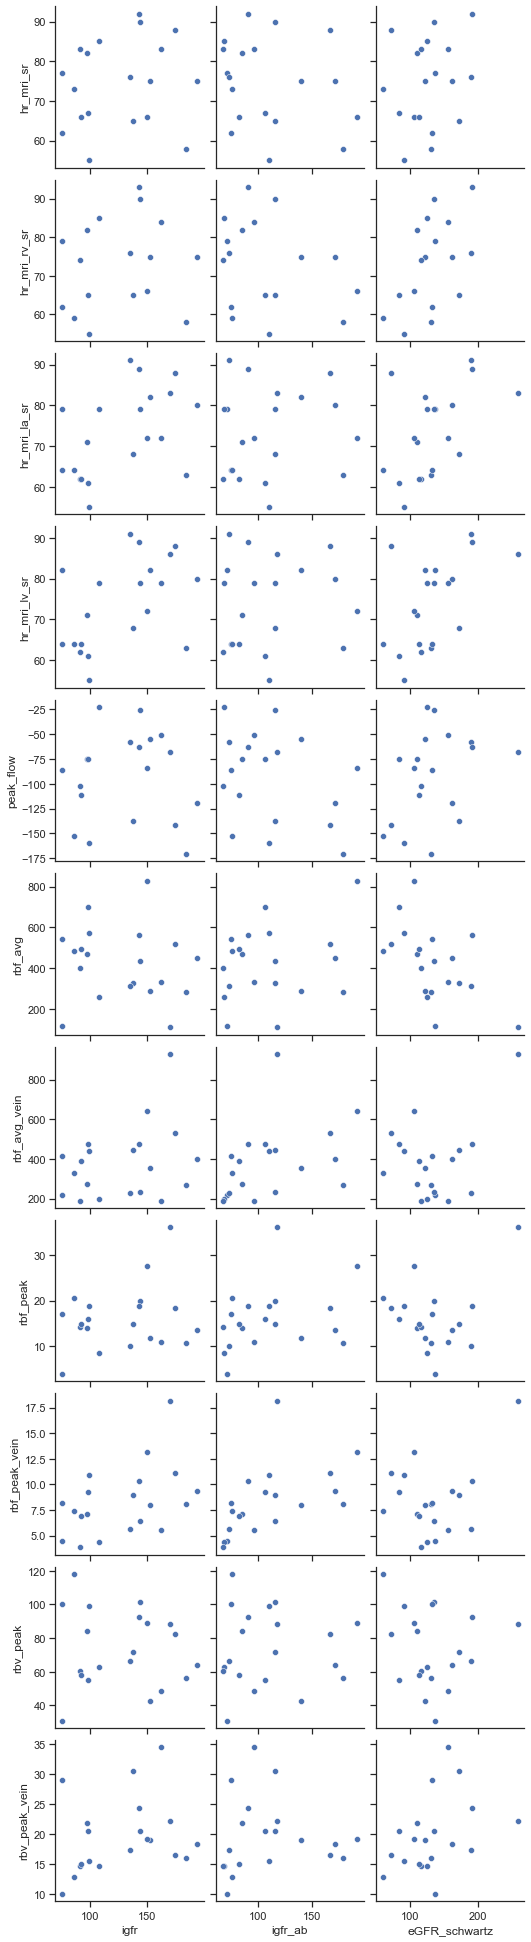

In [3]:
sns.set_theme(style="ticks")
sns.pairplot(final_df,x_vars=outcomes,y_vars=pred);

## Lasso

In [4]:
# Model matrices
y,X = dmatrices('igfr~'+'+'.join(pred),data=final_df)
# LOO CV 
regr = LassoCV(cv=X.shape[0],max_iter=10000)
# Fit
regr = regr.fit(X, y.ravel())
# Re-fit with optimized params
model = Lasso(alpha=regr.alpha_)
fit = model.fit(X, y)

### Regularization Paths

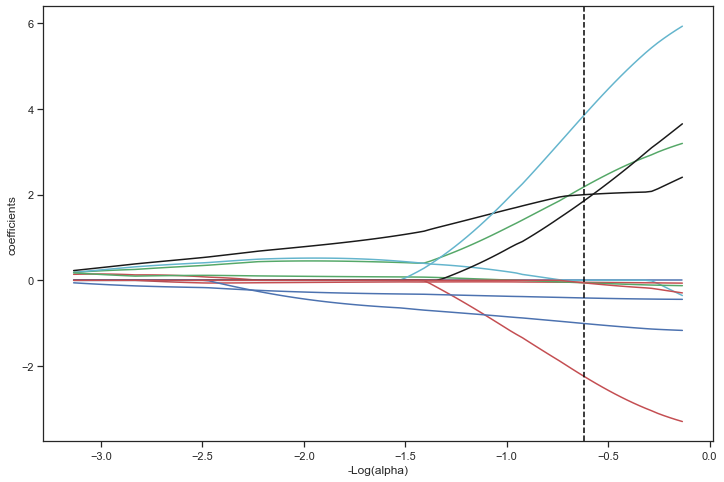

In [5]:
alphas, coefs, _ = fit.path(X, y, alphas=regr.alphas_,max_iter=10000)
# Plot 
plt.rcParams['figure.figsize'] = [12, 8]
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas = -np.log10(alphas)
for coef, c in zip(coefs[0], colors):
    l2 = plt.plot(neg_log_alphas, coef, c=c)
plt.axvline(x = -np.log10(regr.alpha_),color = 'black',linestyle = '--')
plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.axis("tight");

Regularization techniques like the lasso or ElasticNet select regression models by shrinking unimportant model coefficients to 0. The parameter alpha controls the amount of shrinkage applied to the model coefficients, and the optimal value was selected using leave-one-out (LOO) cross validation (CV). The dashed line in the above plot indicates the alpha value selected for this outcome (alpha values are negative log transformed here for better looking plots).

### Selected Variables

In [6]:
idx = [i - 1 for i in list(np.where(fit.coef_ != 0)[0])]
selected = [pred[i] for i in idx]
selected

['hr_mri_sr',
 'hr_mri_rv_sr',
 'hr_mri_lv_sr',
 'peak_flow',
 'rbf_avg',
 'rbf_avg_vein',
 'rbf_peak',
 'rbv_peak']

### Final Model

In [7]:
# Model matrices
y,X = dmatrices('igfr~'+'+'.join(selected),data=final_df,return_type="dataframe")
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   igfr   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     5.870
Date:                Thu, 16 Dec 2021   Prob (F-statistic):             0.0154
Time:                        16:24:31   Log-Likelihood:                -62.941
No. Observations:                  16   AIC:                             143.9
Df Residuals:                       7   BIC:                             150.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -91.9348     79.934     -1.150      0.288    -280.948      97.078
hr_mri_sr       -4.6826      1.637     -2.861      0.024      -8.553      -0.813
hr_mri_rv_sr     4.8555      1.716      2.829      0.025       0.797       8.914
hr_mri_lv_sr     2.6937      0.894      3.013      0.020       0.580       4.808
peak_flow       -0.7206      0.201     -3.578      0.009      -1.197      -0.244
rbf_avg         -0.0370      0.077     -0.478      0.647      -0.220       0.146
rbf_avg_vein    -0.1458      0.095     -1.533      0.169      -0.371       0.079
rbf_peak         7.9995      2.701      2.961      0.021       1.612      14.387
rbv_peak        -1.3377      0.351     -3.815      0.007      -2.167      -0.509
==============================================================================
Omnibus:                        1.432   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.489   Jarque-Bera (JB):                0.843
Skew:                           0.071   Prob(JB):                        0.656
Kurtosis:                       1.885   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Linear Model Residuals

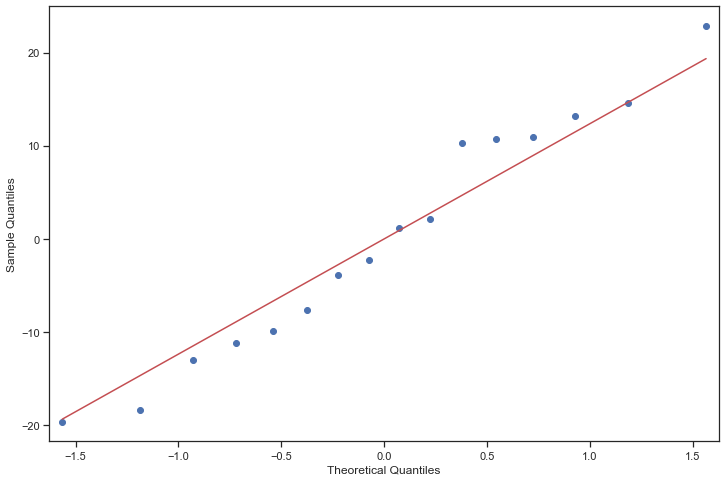

In [8]:
sm.graphics.qqplot(res.resid,line="s");

## Random Forest

In [9]:
# Model matrices
y,X = dmatrices('igfr~'+'+'.join(pred)+'-1',data=final_df,return_type="dataframe")
y.reset_index(inplace=True,drop=True)
X.reset_index(inplace=True,drop=True)
y = np.array(y).ravel()
# Fit RF
rf = RandomForestRegressor(max_features=None,n_jobs=8,random_state=1017)
fit = rf.fit(X,y)

### Compared to Linear Model

RMSE for random forest model:

In [14]:
rf_resid = fit.predict(X) - y
round(np.sqrt(np.mean(abs(rf_resid))),2)

3.31

RMSE for linear model:

In [13]:
round(np.sqrt(np.mean(abs(res.resid))),2)

3.28

The random forest and linear models have almost exactly the same RMSE, althought the linear model performs slightly better.

Petter's FAS code:

In [12]:
# * FAS combined equation, valid for all ages, serumcreat in mg/dL, serumcyst in mg/L, qcr from Pottel reference Table 1 in mg/dL,sex=1 female and sex=2 boys;




# data SUA.casperheirv2;
# set SUA.casperheirv2;



# alpha=0.5;
# if age_current=11 then qcr=0.53;
# if age_current=12 then qcr=0.57;
# if age_current=13 then qcr=0.59;
# if age_current=14 then qcr=0.61;
# if age_current=15 then do; if gender=0 then qcr=0.64; if gender=1 then qcr=0.72; end;
# if age_current=16 then do; if gender=0 then qcr=0.67; if gender=1 then qcr=0.78; end;
# if age_current=17 then do; if gender=0 then qcr=0.69; if gender=1 then qcr=0.82; end;
# if age_current=18 then do; if gender=0 then qcr=0.69; if gender=1 then qcr=0.85; end;
# if age_current=19 then do; if gender=0 then qcr=0.70; if gender=1 then qcr=0.88; end;
# if age_current >=20 then do; if gender=0 then qcr=0.70; if gender=1 then qcr=0.90; end;



# f1 = serum_creatinine/qcr;

# f2 = 1-alpha;



# f3 = cystatin_c/0.82;

# eGFR_cr = 107.3 / f1;
# eGFR_comb = 107.3 / ((alpha*f1) + (f2*f3));



# run;